In [1]:
import random

from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3TokenizerFast
import torch
from PIL import Image
import requests
import pandas as pd
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cpu")  # Use the first GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4070 SUPER


In [2]:
df = pd.read_csv('pic6_df.csv')
df

,txt,confidence,vertices,boundBox,slopes,width,height,direction,mid_point,crop_idx,Left,Top
0,ated,100,"[(0, 187), (74, 194), (71, 226), (0, 219)]","{'Width': 74, 'Height': 39, 'Left': 0, 'Top': ...","(0.034, -3.832)",32.140317,74.330344,horizontal,"(36.25, 206.5)","(0, 0)",0,187
1,808.3,100,"[(184, 1168), (242, 1169), (242, 1183), (184, ...","{'Width': 58, 'Height': 15, 'Left': 184, 'Top'...","(0.006, -300.0)",14.000000,58.008620,horizontal,"(213.0, 1175.5)","(0, 0)",184,1168
2,BUC,100,"[(185, 1193), (218, 1194), (218, 1207), (185, ...","{'Width': 33, 'Height': 14, 'Left': 185, 'Top'...","(0.011, -300.0)",13.000000,33.015148,horizontal,"(201.5, 1200.0)","(0, 0)",185,1193
3,A,100,"[(219, 349), (219, 384), (187, 384), (187, 349)]","{'Width': 32, 'Height': 35, 'Left': 187, 'Top'...","(-300.0, -0.0)",32.000000,35.000000,vertical,"(203.0, 366.5)","(0, 0)",187,349
4,Writer's,100,"[(219, 398), (221, 557), (189, 557), (187, 398)]","{'Width': 34, 'Height': 159, 'Left': 187, 'Top...","(28.558, -0.0)",32.000000,159.012578,vertical,"(204.0, 477.5)","(0, 0)",187,398
...,...,...,...,...,...,...,...,...,...,...,...,...
421,POETRY,100,"[(3871, 560), (3859, 638), (3839, 635), (3851,...","{'Width': 32, 'Height': 81, 'Left': 3839, 'Top...","(-2.335, 0.054)",20.223748,78.917679,vertical,"(3855.0, 597.5)","(0, 0)",3839,557
422,OF,100,"[(3878, 518), (3874, 543), (3853, 540), (3857,...","{'Width': 25, 'Height': 28, 'Left': 3853, 'Top...","(-2.245, 0.051)",21.213203,25.317978,vertical,"(3865.5, 529.0)","(0, 0)",3853,515
423,BOOK,100,"[(3888, 451), (3880, 503), (3860, 500), (3868,...","{'Width': 28, 'Height': 55, 'Left': 3860, 'Top...","(-2.335, 0.054)",20.223748,52.611786,vertical,"(3874.0, 475.5)","(0, 0)",3860,448
424,THE,100,"[(3896, 396), (3890, 436), (3870, 432), (3876,...","{'Width': 26, 'Height': 43, 'Left': 3870, 'Top...","(-2.395, 0.072)",20.396078,40.447497,vertical,"(3883.0, 414.25)","(0, 0)",3870,393


In [3]:
def eval_object_columns(dataframe):
    # Select columns with dtype 'object'
    object_columns = [col for col in dataframe.select_dtypes(include=['object']).columns if col not in ['txt', 'direction']]
    print(object_columns)

    # Iterate over each object column
    for column in object_columns:
        # Apply eval to each item, with error handling
        dataframe[column] = dataframe[column].apply(lambda item: try_eval(item))

    return dataframe

def try_eval(item):
    try:
        # Attempt to evaluate the item
        return eval(item)
    except Exception:
        # Return the item as is in case of an error
        return item

evaled_df = eval_object_columns(df)

['vertices', 'boundBox', 'slopes', 'mid_point', 'crop_idx']


In [4]:
from crop_functions import *
from analyze_book_name_functions import *

image_url = './pics/IMG_7940.jpeg'
image, cropped_img = crop_image(image_url)

No need to be cropped


In [5]:
text_df = analyze_text_location(evaled_df, image)
related_text = group_related_text(text_df)
related_text

{0: [(0, 'ated', (36.25, 206.5), 0.0)],
 1: [(1, '808.3', (213.0, 1175.5), 0.0),
  (8, 'SETTING', (212.0, 1036.0), 0.40268698189331176)],
 2: [(2, 'BUC', (201.5, 1200.0), 0.0)],
 3: [(3, 'A', (203.0, 366.5), 0.0),
  (4, "Writer's", (204.0, 477.5), 0.5528039401361292)],
 4: [(4, "Writer's", (204.0, 477.5), 0.0),
  (2, 'BUC', (201.5, 1200.0), 0.7660965957107206),
  (3, 'A', (203.0, 366.5), 0.19942600096303986),
  (5, 'Guide', (206.5, 629.0), 0.37462971159522324),
  (6, 'To', (207.0, 711.0), 0.4983362464384334),
  (7, 'ACTIVE', (208.5, 832.0), 0.7516252954289246)],
 5: [(5, 'Guide', (206.5, 629.0), 0.0),
  (2, 'BUC', (201.5, 1200.0), 0.8767852705381596),
  (3, 'A', (203.0, 366.5), 0.6235488781240242),
  (4, "Writer's", (204.0, 477.5), 0.3988296839016135),
  (6, 'To', (207.0, 711.0), 0.15275048442281672),
  (7, 'ACTIVE', (208.5, 832.0), 0.4289051153805221),
  (8, 'SETTING', (212.0, 1036.0), 0.9725829944075008)],
 6: [(6, 'To', (207.0, 711.0), 0.0),
  (5, 'Guide', (206.5, 629.0), 0.49719384

In [6]:
def sort_and_trim_dict(dict_data, n=5):
    """
    For each list in the dictionary, sort the tuples by the last element
    and trim the list to keep only the first n tuples.
    
    Parameters:
    dict_data (dict): The input dictionary with list of tuples as values.
    n (int): Number of tuples to keep in each list after sorting.
    
    Returns:
    dict: The updated dictionary with sorted and trimmed lists.
    """

    def custom_sort_key(tup):
        # If tuple has more than 3 elements, use the last element for sorting
        if len(tup) > 3:
            return tup[-1]
        else:
            # Otherwise, use the last element of the 3rd item (assuming it's a tuple)
            return tup[2][-1]

    for key in dict_data:
        # Sort the list of tuples using the custom sort function and trim it
        sorted_list = sorted(dict_data[key], key=custom_sort_key)[:n]
        dict_data[key] = sorted_list

    return dict_data

trim_df = sort_and_trim_dict(related_text)

In [7]:
trim_df

{0: [(0, 'ated', (36.25, 206.5), 0.0)],
 1: [(1, '808.3', (213.0, 1175.5), 0.0),
  (8, 'SETTING', (212.0, 1036.0), 0.40268698189331176)],
 2: [(2, 'BUC', (201.5, 1200.0), 0.0)],
 3: [(3, 'A', (203.0, 366.5), 0.0),
  (4, "Writer's", (204.0, 477.5), 0.5528039401361292)],
 4: [(4, "Writer's", (204.0, 477.5), 0.0),
  (3, 'A', (203.0, 366.5), 0.19942600096303986),
  (5, 'Guide', (206.5, 629.0), 0.37462971159522324),
  (6, 'To', (207.0, 711.0), 0.4983362464384334),
  (7, 'ACTIVE', (208.5, 832.0), 0.7516252954289246)],
 5: [(5, 'Guide', (206.5, 629.0), 0.0),
  (6, 'To', (207.0, 711.0), 0.15275048442281672),
  (4, "Writer's", (204.0, 477.5), 0.3988296839016135),
  (7, 'ACTIVE', (208.5, 832.0), 0.4289051153805221),
  (3, 'A', (203.0, 366.5), 0.6235488781240242)],
 6: [(6, 'To', (207.0, 711.0), 0.0),
  (5, 'Guide', (206.5, 629.0), 0.4971938405242638),
  (7, 'ACTIVE', (208.5, 832.0), 0.7528241086732177)],
 7: [(7, 'ACTIVE', (208.5, 832.0), 0.0),
  (6, 'To', (207.0, 711.0), 0.24091745829283906),
 

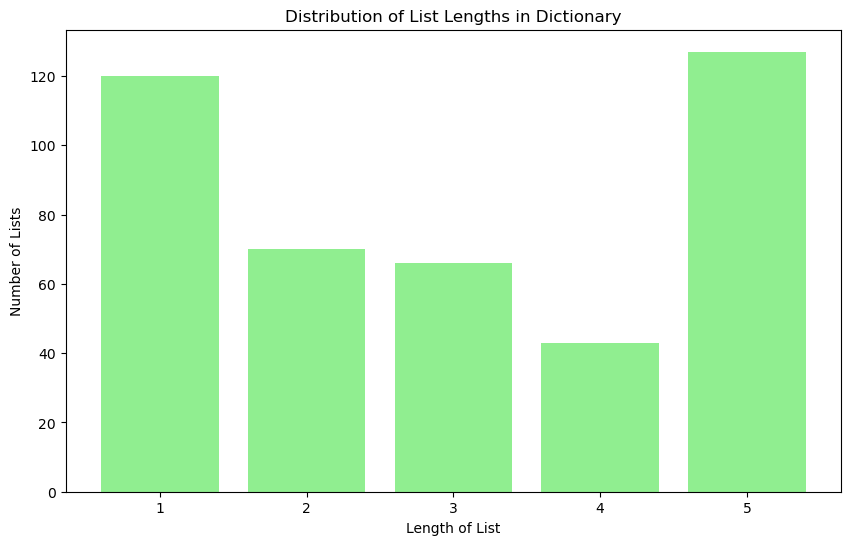

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_list_length_distribution(dict_data):
    """
    Plots a bar chart with list lengths on the x-axis and the number of lists with each length on the y-axis.
    
    Parameters:
    dict_data (dict): The input dictionary with lists as values.
    """
    # Compute the length of each list in the dictionary
    list_lengths = [len(lst) for lst in dict_data.values()]

    # Count the frequency of each list length
    length_counts = Counter(list_lengths)

    # Sorting the lengths for a coherent x-axis
    lengths_sorted = sorted(length_counts.keys())
    frequencies = [length_counts[length] for length in lengths_sorted]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(lengths_sorted, frequencies, color='lightgreen')
    plt.xlabel('Length of List')
    plt.ylabel('Number of Lists')
    plt.title('Distribution of List Lengths in Dictionary')
    plt.xticks(lengths_sorted)  # Ensure all lengths are shown as x-axis labels
    plt.show()


plot_list_length_distribution(trim_df)

In [10]:
filtered_data = remove_duplicates(trim_df)

In [11]:
filtered_data

{0: [(0, 'ated', (36.25, 206.5), 0.0)],
 4: [(4, "Writer's", (204.0, 477.5), 0.0),
  (3, 'A', (203.0, 366.5), 0.19942600096303986),
  (5, 'Guide', (206.5, 629.0), 0.37462971159522324),
  (6, 'To', (207.0, 711.0), 0.4983362464384334),
  (7, 'ACTIVE', (208.5, 832.0), 0.7516252954289246)],
 7: [(7, 'ACTIVE', (208.5, 832.0), 0.0),
  (6, 'To', (207.0, 711.0), 0.24091745829283906),
  (5, 'Guide', (206.5, 629.0), 0.3589778027205887),
  (8, 'SETTING', (212.0, 1036.0), 0.49489443699139374),
  (2, 'BUC', (201.5, 1200.0), 0.6248102954743198)],
 8: [(8, 'SETTING', (212.0, 1036.0), 0.0),
  (1, '808.3', (213.0, 1175.5), 0.20848505818620963),
  (7, 'ACTIVE', (208.5, 832.0), 0.48839088301935973),
  (6, 'To', (207.0, 711.0), 0.7239822067961558),
  (5, 'Guide', (206.5, 629.0), 0.8360655579123908)],
 12: [(12, 'CRA', (280.5, 1207.0), 0.0)],
 14: [(14, 'CRAFTING', (293.0, 557.0), 0.0),
  (15, 'DYNAMIC', (295.0, 748.5), 0.353535744703047),
  (11, '808.3', (291.5, 1184.0), 0.5928887658894231),
  (16, 'DIALO